In [2]:
!pip install datasets transformers evaluate imbalanced-learn umap-learn wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=2a424b3e34710579cfd8c9d394b06fb77cfc13a7b6e9ffc3945841516ce7fc4d
  Stored in directory: /root/.cache/pip/wheels/5c/1b/45/fe9669fd510011e10b9391ac99093bcd9f5327b18e8a928869
Successfully built umap


In [3]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
from datasets import load_dataset

health_fact = load_dataset('health_fact')

Generating train split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1235 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1225 [00:00<?, ? examples/s]

Dataset health_fact downloaded and prepared to /root/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
# Filter out instances with a -1 label
health_fact['train'] = health_fact['train'].filter(lambda x: x['label'] != -1)
health_fact['validation'] = health_fact['validation'].filter(lambda x: x['label'] != -1)
health_fact['test'] = health_fact['test'].filter(lambda x: x['label'] != -1)

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [8]:
health_fact.set_format(type="pandas")
df = health_fact["train"][:]
df.head()

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,0,"Foreign Policy, PunditFact, Newt Gingrich,"
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,1,"Screening,WebMD,women's health"
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,1,"Association/Society news release,Cancer"
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,2,"Cancer,WebMD,women's health"
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,2,


In [9]:
def label_int2str(row):
    if row == -1:
        return 'invalid'
    return health_fact["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)

In [10]:
df.head()

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,label_name
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,0,"Foreign Policy, PunditFact, Newt Gingrich,",false
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,1,"Screening,WebMD,women's health",mixture
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,1,"Association/Society news release,Cancer",mixture
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,2,"Cancer,WebMD,women's health",true
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,2,,true


Text(0.5, 1.0, 'Frequency of Classes')

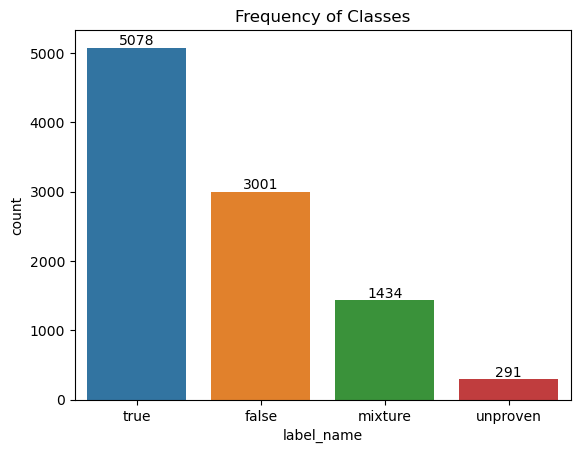

In [11]:
# df["label_name"].value_counts(ascending=True).plot.barh()

ax = sns.countplot(x='label_name', data=df, order = df['label_name'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.title("Frequency of Classes")

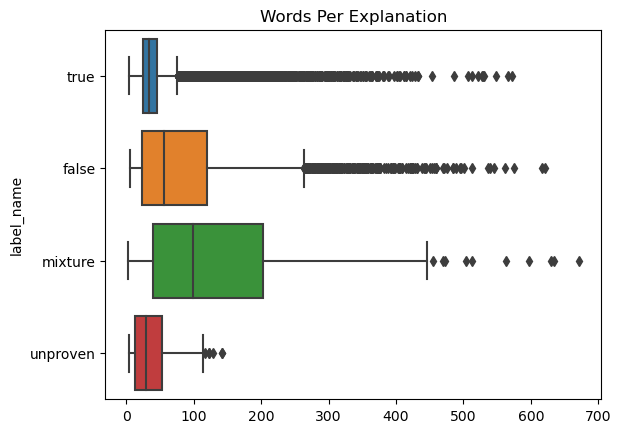

In [12]:
df['Words Per Explanation'] = df['explanation'].str.split().apply(len)
sns.boxplot(x=df['Words Per Explanation'], y=df['label_name'], data=df, order = df['label_name'].value_counts().index)
plt.title("Words Per Explanation")
plt.xlabel("")
plt.show()

In [13]:
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [14]:
# checkpoint = "bert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# tokenized_explanations = tokenizer(health_fact["train"]["explanation"], max_length=512, truncation=True, padding=True, return_tensors="pt")

In [15]:
health_fact.reset_format()

In [16]:
def tokenize(batch):
    return tokenizer(batch['explanation'], truncation=True, padding=True)

In [17]:
health_fact_encoded = health_fact.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [18]:
print(health_fact_encoded["train"].column_names)

['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects', 'input_ids', 'attention_mask']


In [19]:
import torch
from transformers import AutoModel

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [21]:
health_fact_encoded.set_format('torch', columns=["input_ids", "attention_mask", "label"])

In [22]:
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage()  

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=3b40a5766c6d51ba320bfa8c1b312ea265342a23b3daf3a257902879454d84cc
  Stored in directory: /root/.cache/pip/wheels/b1/e7/99/2b32600270cf23194c9860f029d3d5db075f250bc39028c045
Successfully built GPUtil
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
----------

In [23]:
del df

In [24]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [25]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()  

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 |  0% |  6% |


In [26]:
health_fact_hidden = health_fact_encoded.map(extract_hidden_states, batched=True, batch_size=100)

  0%|          | 0/99 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

In [27]:
import numpy as np

X_train = np.array(health_fact_hidden["train"]["hidden_state"])
X_valid = np.array(health_fact_hidden["validation"]["hidden_state"])
y_train = np.array(health_fact_hidden["train"]["label"])
y_valid = np.array(health_fact_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((9804, 768), (1214, 768))

In [28]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

ImportError: cannot import name 'UMAP' from 'umap' (/opt/conda/lib/python3.7/site-packages/umap/__init__.py)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(5,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Greens"]
labels = health_fact["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)


In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 4
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))


In [34]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 32
logging_steps = len(health_fact_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-health-fact"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
gpu_usage() 

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=health_fact_encoded["train"],
                  eval_dataset=health_fact_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

In [29]:
import wandb
wandb.init(project="pubhealth-hyperparameter-search")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
num_labels=4
# Define the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Function to train and evaluate the model with given hyperparameters
def train_evaluate_model(learning_rate, batch_size, weight_decay, dropout_rate):
    model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=4,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        dropout_rate=dropout_rate,
        logging_dir='./logs',
        logging_steps=100,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        report_to="wandb",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        patience=1,  # Number of epochs with no improvement after which training will be stopped
    )

    trainer = Trainer(
        model=model, 
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=health_fact_encoded["train"],
        eval_dataset=health_fact_encoded["validation"],
        tokenizer=tokenizer
    )

    # Train the model
    trainer.train()

    # Evaluate the model on the validation set
    results = trainer.evaluate(health_fact_encoded["validation"])

    # Log the hyperparameters and results in wandb
    wandb.log({
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "dropout_rate": dropout_rate,
        "accuracy": results["eval_accuracy"],
    })

# Perform hyperparameter search
learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [8, 16]
weight_decays = [0.0, 0.01]
dropout_rates = [0.1, 0.3]

for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for weight_decay in weight_decays:
            for dropout_rate in dropout_rates:
                train_evaluate_model(learning_rate, batch_size, weight_decay, dropout_rate)


# Close wandb
wandb.finish()

In [37]:
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
num_labels=4
# Define the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def main(verbose=False):
    # Initialise run
    run = wandb.init()
    model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=4,
        per_device_train_batch_size=wandb.config.batch_size,
        per_device_eval_batch_size=wandb.config.batch_size,
        learning_rate=wandb.config.learning_rate,
        weight_decay=wandb.config.weight_decay,
        dropout_rate=wandb.config.dropout_rate,
        logging_dir='./logs',
        logging_steps=100,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        report_to="wandb",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        patience=1,  # Number of epochs with no improvement after which training will be stopped
    )

    trainer = Trainer(
        model=model, 
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=health_fact_encoded["train"],
        eval_dataset=health_fact_encoded["validation"],
        tokenizer=tokenizer
    )

    # Train the model
    trainer.train()

    # Evaluate the model on the validation set
    results = trainer.evaluate(health_fact_encoded["validation"])

    # Log the hyperparameters and results in wandb
    wandb.log({
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "dropout_rate": dropout_rate,
        "accuracy": results["eval_accuracy"],
    })

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

In [38]:
sweep_configuration = {
    'method': 'bayes',  # random, grid or bayes
    'name': 'sweep-bayes',
    'metric': {'goal': 'maximize', 'name': 'eval_accuracy'},
    'parameters': 
    {
        'batch_size': {'values': [8, 16, 32]},
        'learning_rate': {'max': 0.1, 'min': 0.0001},
        'weight_decays': {'values': [0.0, 0.1, 0.2]},
        'dropout_rate': {'max': 0.5, 'min': 0.1}
     }
}

In [39]:
sweep_id = wandb.sweep(sweep=sweep_configuration, entity='tansaku', project='pubhealth-hyperparameter-search')

Create sweep with ID: iny1lp3a
Sweep URL: https://wandb.ai/tansaku/pubhealth-hyperparameter-search/sweeps/iny1lp3a


In [ ]:
# Maximum 'count' runs
wandb.agent(sweep_id, function=main, count=2)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingfac

wandb: ERROR Run mtwnyq3a errored: AttributeError("<class 'wandb.sdk.wandb_config.Config'> object has no attribute 'weight_decay'")
